In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Flatten, Concatenate, Input, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 뉴스 카테고리
https://www.kaggle.com/rmisra/news-category-dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd

# json 읽어오기
news_data = pd.read_json('/content/drive/My Drive/Colab Notebooks/ai_school/data/News_Category_Dataset_v2.json', lines=True)
# print(news_data)

news_data = news_data.loc[:, ["category", "headline"]] # 필요한 열만 추출
# print(news_data)

# 카테고리 정수 인코딩 (문자인 카테고리를 숫자로 변경)
'''
# 직접 하는 방법
category_list = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 
                 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK', 'BUSINESS',
                 'COMEDY', 'SPORTS', 'BLACK VOICES', 'HOME & LIVING', 'PARENTS', 
                 'THE WORLDPOST', 'WEDDINGS', 'WOMEN', 'IMPACT', 'DIVORCE', 
                 'CRIME', 'MEDIA', 'WEIRD NEWS', 'GREEN', 'WORLDPOST',
                 'RELIGION', 'STYLE', 'SCIENCE', 'WORLD NEWS', 'TASTE', 
                 'TECH', 'MONEY', 'ARTS', 'FIFTY', 'GOOD NEWS',
                 'ARTS & CULTURE', 'ENVIRONMENT', 'COLLEGE', 'LATINO VOICES', 'CULTURE & ARTS',
                 'EDUCATION']
nums = [i for i in range(41)]

news_data['category'] = news_data['category'].replace(category_list, nums)
'''

# 더 간단한 방법
category_list = pd.factorize(news_data['category'])[1]
news_data['category'] = pd.factorize(news_data['category'])[0]

print(news_data)

        category                                           headline
0              0  There Were 2 Mass Shootings In Texas Last Week...
1              1  Will Smith Joins Diplo And Nicky Jam For The 2...
2              1    Hugh Grant Marries For The First Time At Age 57
3              1  Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4              1  Julianna Margulies Uses Donald Trump Poop Bags...
...          ...                                                ...
200848        14  RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849        10  Maria Sharapova Stunned By Victoria Azarenka I...
200850        10  Giants Over Patriots, Jets Over Colts Among  M...
200851        10  Aldon Smith Arrested: 49ers Linebacker Busted ...
200852        10  Dwight Howard Rips Teammates After Magic Loss ...

[200853 rows x 2 columns]


In [4]:
# 정규표현식 사용
news_data['headline'] = news_data['headline'].str.replace("[^\w]", " ")

In [5]:
from sklearn.model_selection import train_test_split

# split하면서 shuffle 적용
news_train, news_test, y_train, y_test = train_test_split(news_data['headline'], news_data['category'], test_size=0.2, shuffle=True, random_state=23)

# 원핫벡터로 만들어 준다. (num_classes로 카테고리 수 명시 가능)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(len(y_train[0]))
print(len(y_test[0]))

41
41


In [6]:
# 토큰화 진행
stopwords = ['a', 'an']

X_train = []
for stc in news_train:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_train.append(token)

X_test = []
for stc in news_test:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_test.append(token)

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 헤드라인 정수인코딩
tokenizer = Tokenizer(25000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [8]:
print(len(tokenizer.word_index))

wc = 0
for word, word_count in tokenizer.word_counts.items():
    if word_count <= 2:
        wc += 1

print(wc)

50923
26916


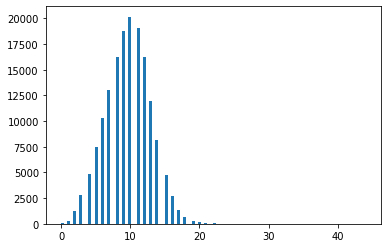

In [9]:
import matplotlib.pyplot as plt

len_stc = []
for data in X_train:
    len_stc.append(len(data))

y, x, _ = plt.hist(len_stc, bins=100)
plt.show()

In [10]:
max_len = 15
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [11]:
model = Sequential()
model.add(Embedding(25000, 128))
model.add(LSTM(128))
model.add(Dense(41, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=1)

2511/2511 [==============================] - 106s 42ms/step - loss: 1.9860 - acc: 0.4760 - val_loss: 1.5621 - val_acc: 0.5683


In [13]:
sentence = input()
token_stc = sentence.split()
encode_stc = tokenizer.texts_to_sequences([token_stc])
pad_stc = pad_sequences(encode_stc, maxlen=15)

score = model.predict(pad_stc)
print(category_list[score.argmax()], score[0, score.argmax()])

apple
WELLNESS 0.13123709


# 트위터 감정 분석
https://www.kaggle.com/maxjon/complete-tweet-sentiment-extraction-data/

In [14]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

tweet_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ai_school/data/tweet_dataset.csv')
# print(tweet_data)
tweet_data = tweet_data.loc[: , ["sentiment", "text"]]
# print(tweet_data)
tweet_data = tweet_data.dropna(how='any')

# 감정 인코딩
print(pd.factorize(tweet_data['sentiment']))
tweet_data['sentiment'] = pd.factorize(tweet_data['sentiment'])[0]
print(tweet_data)

(array([0, 1, 1, ..., 6, 9, 6]), Index(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype='object'))
       sentiment                                               text
0              0   i know  i was listenin to bad habit earlier a...
1              1  Layin n bed with a headache  ughhhh...waitin o...
2              1                Funeral ceremony...gloomy friday...
3              2               wants to hang out with friends SOON!
4              3   We want to trade with someone who has Houston...
...          ...                                                ...
39994          9                      Succesfully following Tayla!!
39996          6                     Happy Mothers Day  All my love
39997          6  Happy Mother`s Day to all the mommies out ther...
39998          9   WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEEP OUT MY ...
39999          6   bullet train from tokyo    the

In [15]:
# 정규표현식 써서 단어 아니면 삭제
tweet_data['text'] = tweet_data['text'].str.replace("[^\w]", " ")

In [16]:
# test/train 스플릿
tweet_train, tweet_test, y_train, y_test = train_test_split(tweet_data['text'], tweet_data['sentiment'], test_size=0.2, shuffle=True, random_state=23)

# 원핫벡터화
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(len(y_train[0]))
print(len(y_test[0]))

13
13


In [17]:
from nltk.tokenize import WordPunctTokenizer

# nltk stopwords 리스트
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

# 토큰화 진행
X_train = []
for stc in tweet_train:
    token = []
    words = WordPunctTokenizer().tokenize(stc)
    for word in words:
        if word.lower() not in stopwords:
            token.append(word.lower())
    X_train.append(token)

X_test = []
for stc in tweet_test:
    token = []
    words = WordPunctTokenizer().tokenize(stc)
    for word in words:
        if word.lower() not in stopwords:
            token.append(word.lower())
    X_test.append(token)

# print(X_train[:3])

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 트윗 정수인코딩
tokenizer = Tokenizer(10000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [19]:
print(X_train[:3])

[[157, 92, 35, 854, 2171, 332, 132, 695, 25, 4266, 54, 39, 221, 2296], [9, 37, 238, 362, 263], [10, 4267, 3762, 603, 196, 345]]


In [20]:
print(len(tokenizer.word_index))
low_count = 0
for word, word_count in tokenizer.word_counts.items():
    if word_count > 1:
        low_count += 1
print(low_count)

28841
11287


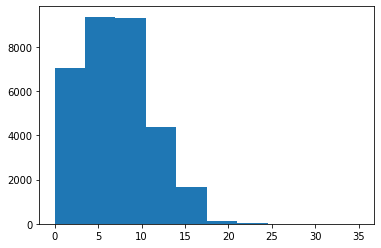

6.877202867248881
9360.0
35.0
[3.5]


In [21]:
# 문장의 최대 길이 구하기
import matplotlib.pyplot as plt

len_stc = []
for data in X_train:
    len_stc.append(len(data))

y, x, _ = plt.hist(len_stc)
plt.show()
print(sum(len_stc)/len(len_stc))
print(y.max())
print(x.max())
print(x[np.where(y == y.max())])

In [22]:
max_len = 25
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [23]:
print(y_train[1])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [24]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(LSTM(32))
model.add(Dense(13, activation='softmax'))

In [25]:
from tensorflow.keras.layers import Dropout

# 함수형 케라스
inputs = Input(shape=(25,))
embed = Embedding(10000, 32)(inputs)
drop = Dropout(0.3)(embed)

# 모델 합성
concat_layers = []

conv = Conv1D(32, 1, padding='same', activation='relu')(drop)
pool = GlobalMaxPooling1D()(conv)
flat = Flatten()(pool)
concat_layers.append(flat)

conv = Conv1D(32, 2, padding='same', activation='relu')(drop)
pool = GlobalMaxPooling1D()(conv)
flat = Flatten()(pool)
concat_layers.append(flat)

conv = Conv1D(32, 3, padding='same', activation='relu')(drop)
pool = GlobalMaxPooling1D()(conv)
flat = Flatten()(pool)
concat_layers.append(flat)
######
concat = Concatenate()(concat_layers)
relu = Dense(64, activation='relu')(concat)
drop = Dropout(0.5)(relu)

outputs = Dense(13, activation="softmax")(drop)

model = Model(inputs, outputs)

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10)

Epoch 1/10
500/500 [==============================] - 5s 11ms/step - loss: 2.1636 - acc: 0.2450 - val_loss: 2.0312 - val_acc: 0.3230
Epoch 2/10
500/500 [==============================] - 5s 10ms/step - loss: 2.0028 - acc: 0.3251 - val_loss: 1.9389 - val_acc: 0.3481
Epoch 3/10
500/500 [==============================] - 5s 10ms/step - loss: 1.9426 - acc: 0.3526 - val_loss: 1.9221 - val_acc: 0.3552
Epoch 4/10
500/500 [==============================] - 5s 10ms/step - loss: 1.8987 - acc: 0.3641 - val_loss: 1.9110 - val_acc: 0.3537
Epoch 5/10
500/500 [==============================] - 5s 10ms/step - loss: 1.8666 - acc: 0.3741 - val_loss: 1.9053 - val_acc: 0.3523
Epoch 6/10
500/500 [==============================] - 5s 10ms/step - loss: 1.8387 - acc: 0.3854 - val_loss: 1.9061 - val_acc: 0.3576
Epoch 7/10
500/500 [==============================] - 5s 10ms/step - loss: 1.8160 - acc: 0.3950 - val_loss: 1.9108 - val_acc: 0.3606
Epoch 8/10
500/500 [==============================] - 5s 10ms/step - 

In [27]:
sentence = input()
# 토큰화
token_stc = sentence.split()
# 정수 인코딩
encode_stc = tokenizer.texts_to_sequences([token_stc])
# 패딩
pad_stc = pad_sequences(encode_stc, maxlen = 25)

score = model.predict(pad_stc)

sent_list = ['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', 'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger']

print(sent_list[score.argmax()], score[0, score.argmax()])

cry
sadness 0.5431041
